# Buy Low, Sell High
## Backtesting a Long-Term Rolling Average Investment Strategy vs. Dollar Cost Averaging

## By: Jeff Hale

### "Buy low and sell high" is standard investment advice. 

However, investors buy when they think the price is going to rise and sell when they think the price is going to fall lower. Often times investors are chasing the market. They sell when fear has taken over and prices have already fallen. They buy when everyone is euphoric and prices are already high. 

Let's buy when things are below the 20 year moving average.

I'm certainly not the first person to test an investment strategy like this one, but dollar cost averaging seems to be the prevailing wisdom. This is also a good exercise in building a basic back-testing process with python, pandas, and numpy.

Dollar cost averaging is another recommended investment strategy. Let's use that as a baseline. 

Rough plan:

1. Import S&P 500 monthly data, from [Quandl](https://www.quandl.com). 
2. Build DataFrames.
3. Code strategies to buy and sell based on triggers. 
4. Evaluate.
5. Iterate.

We'll use the inflation adjusted data.

Wwe want to make sure we go back a good ways. The past thirty year's in the US economy have had their ups and downs, but money has largely been cheap and inflation has largely been low. We'll look at data going back 50 years for this example.

Let's code and and evaluate.

## Assumptions

For our simulations, let's say you are an individual investor with 1k of cash to invest per month. 

We'll assume you can invest this tax free in a retirement account. 

Transaction cost is assumed to be zero with [Vanguard](https://investor.vanguard.com/etf/profile/fees/voo) S&P 500 ETF (VOOO) because it is free to buy and sell.

Expense ratio is 0.04 percent.
Quarterly distributions per share from the fund have been over one dollar for past few quarters. -per share whatever
Based on historic performance, there are expected to be no taxable capital gains distributions.
Shares are currently $229.64 as of Jan. 2, 2019, COB.

For now, we'll exclude the above concerns.

In [1]:
# essentials
import pdb
import numpy as np 
import pandas as pd 

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# quandl
import quandl

# reproducibility
np.random.seed(34)

# Jupyter magic
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# formatting
sns.set()
pd.options.display.float_format = '{:,.2f}'.format

## Price Data

We need the S&P 500 price data. 

We can get inflation adjusted or non-inflation adjusted monthly price. We'll use inflation adjusted for real returns.

We'll specify that we want the result in a numpy array. 

Insert your own authtoken. Tokens are free at Quandl.

In [2]:
price_data = quandl.get(
    "MULTPL/SP500_INFLADJ_MONTH", 
    authtoken="17ShEkbGYrhcJ7Qw8DvJ", # use your own free auth token, please
    returns="numpy"
)

In [3]:
df = pd.DataFrame(price_data)
df.tail(20)

,Date,Value
1761,2017-10-01,"2,612.72"
1762,2017-11-01,"2,650.06"
1763,2017-12-01,"2,723.93"
1764,2018-01-01,"2,836.75"
1765,2018-02-01,"2,738.26"
1766,2018-03-01,"2,729.67"
1767,2018-04-01,"2,669.43"
1768,2018-05-01,"2,706.32"
1769,2018-06-01,"2,754.89"
1770,2018-07-01,"2,793.99"


We have a few months with both the beginning and ending dates. Even data meant to be consumed from a financial data firm is a bit messy!

Let's drop the duplicate months and plot.

In [4]:
df = df.drop([1773, 1776, 1778])

In [5]:
df.tail()

,Date,Value
1774,2018-10-01,"2,776.13"
1775,2018-11-01,"2,723.23"
1777,2018-12-01,"2,567.31"
1779,2019-01-01,"2,584.96"
1780,2019-02-01,"2,706.71"


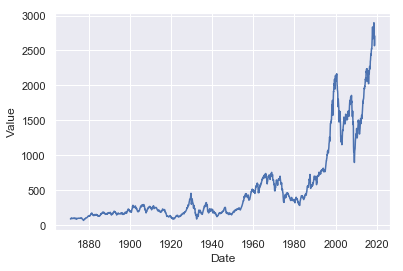

In [6]:
sns.lineplot(data=df, x='Date', y='Value')

That chart always makes me nervous. Stock market curves that go up like that usually come back to earth eventually. This one is inflation adjusted, too.

## Compute Moving Average

Let's make a 20 year moving average. We'll set 20 as a constant.

In [7]:
# years to lookback for rolling average
LOOKBACK = 20 

First we need to move the date into the index. 

In [8]:
df = df.set_index('Date')
df.head()

,Value
Date,
1871-01-01,89.81
1871-02-01,88.33
1871-03-01,89.17
1871-04-01,95.12
1871-05-01,99.83


type(df.index)

Looks good.

## Create rolling average column 

In [9]:
df['moving_avg'] = df['Value'].rolling((12*LOOKBACK)).mean()

In [10]:
df.head()

,Value,moving_avg
Date,,
1871-01-01,89.81,nan
1871-02-01,88.33,nan
1871-03-01,89.17,nan
1871-04-01,95.12,nan
1871-05-01,99.83,nan


In [11]:
df.tail()

,Value,moving_avg
Date,,
2018-10-01,"2,776.13","1,757.55"
2018-11-01,"2,723.23","1,761.57"
2018-12-01,"2,567.31","1,764.64"
2019-01-01,"2,584.96","1,767.43"
2019-02-01,"2,706.71","1,770.75"


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1778 entries, 1871-01-01 to 2019-02-01
Data columns (total 2 columns):
Value         1778 non-null float64
moving_avg    1539 non-null float64
dtypes: float64(2)
memory usage: 41.7 KB


We're going to have nan's for the first 20 years of data because there isn't data to look back over and average. That's fine. We're not that concerned about returns from the 1800s anyway. Those are less likely to have meaningful information for today's investments than more recent data.

Let's drop those rows with nans.

In [13]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1539 entries, 1890-12-01 to 2019-02-01
Data columns (total 2 columns):
Value         1539 non-null float64
moving_avg    1539 non-null float64
dtypes: float64(2)
memory usage: 36.1 KB


Cool. We dropped our nan columns.

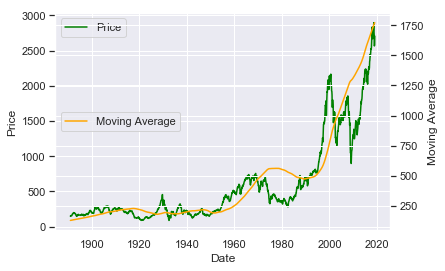

In [14]:
ax1 = sns.lineplot(data=df, x=df.index, y='Value', color='green')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax2 = plt.twinx()
ax2 = sns.lineplot(data=df, x=df.index, y='moving_avg', color='orange')
ax2.set_ylabel('Moving Average')
ax1.legend(labels=["Price"], loc = 'upper left')
ax2.legend(labels=["Moving Average"], loc = 'center left')

## Create Standard Deviation Columns and Buy/Sell Signals
Now let's implement our trading strategy. 
Let's try buying when the price is 1 standard deviation below the rolling average.

In [15]:
df.moving_avg.std()

393.5143334800675

Let's make a column for the std dev and a column for our buy signal.

In [16]:
df['moving_avg_sd'] = df.moving_avg.rolling((12*LOOKBACK)).std()
df.tail()

,Value,moving_avg,moving_avg_sd
Date,,,
2018-10-01,"2,776.13","1,757.55",287.44
2018-11-01,"2,723.23","1,761.57",286.95
2018-12-01,"2,567.31","1,764.64",286.46
2019-01-01,"2,584.96","1,767.43",285.97
2019-02-01,"2,706.71","1,770.75",285.50


if moving

In [17]:
df['buy'] = df.Value < (df.moving_avg - df.moving_avg_sd)
df.tail()

,Value,moving_avg,moving_avg_sd,buy
Date,,,,
2018-10-01,"2,776.13","1,757.55",287.44,False
2018-11-01,"2,723.23","1,761.57",286.95,False
2018-12-01,"2,567.31","1,764.64",286.46,False
2019-01-01,"2,584.96","1,767.43",285.97,False
2019-02-01,"2,706.71","1,770.75",285.50,False


In [18]:
df.buy.value_counts()

False    1164
True      375
Name: buy, dtype: int64

Ok. We'd buy 254 months. Let's make a *sell* column for when the values is greater than 1 std deviation above the average.

In [19]:
df['sell'] = df.Value > (df.moving_avg + df.moving_avg_sd)
df.tail()

,Value,moving_avg,moving_avg_sd,buy,sell
Date,,,,,
2018-10-01,"2,776.13","1,757.55",287.44,False,True
2018-11-01,"2,723.23","1,761.57",286.95,False,True
2018-12-01,"2,567.31","1,764.64",286.46,False,True
2019-01-01,"2,584.96","1,767.43",285.97,False,True
2019-02-01,"2,706.71","1,770.75",285.50,False,True


In [20]:
df.sell.value_counts()

False    810
True     729
Name: sell, dtype: int64

Ok. We'd sell just over half the time.

## Trading

Let's add a column for the % change in price

In [21]:
df['pct_change'] = df['Value'].pct_change()
df.tail()

,Value,moving_avg,moving_avg_sd,buy,sell,pct_change
Date,,,,,,
2018-10-01,"2,776.13","1,757.55",287.44,False,True,-0.04
2018-11-01,"2,723.23","1,761.57",286.95,False,True,-0.02
2018-12-01,"2,567.31","1,764.64",286.46,False,True,-0.06
2019-01-01,"2,584.96","1,767.43",285.97,False,True,0.01
2019-02-01,"2,706.71","1,770.75",285.50,False,True,0.05


Let's add columns for uninvested cash value, invested value, and total value.

In [22]:
df['cash_bal'] = 0
df['invested_bal'] = 0
df['total_bal'] = df.cash_bal + df.invested_bal
df.tail()

,Value,moving_avg,moving_avg_sd,buy,sell,pct_change,cash_bal,invested_bal,total_bal
Date,,,,,,,,,
2018-10-01,"2,776.13","1,757.55",287.44,False,True,-0.04,0,0,0
2018-11-01,"2,723.23","1,761.57",286.95,False,True,-0.02,0,0,0
2018-12-01,"2,567.31","1,764.64",286.46,False,True,-0.06,0,0,0
2019-01-01,"2,584.96","1,767.43",285.97,False,True,0.01,0,0,0
2019-02-01,"2,706.71","1,770.75",285.50,False,True,0.05,0,0,0


## Variables 
Let's set our variables. We have 1k per month of new cash in from our non-investment earnings (e.g. our wages).

We'll buy with 20% our cash balance if our buy signal is reached.
We'll sell 20% of our invested value if our sell signal is reached.


In [23]:
def allocate_gain_loss():
    # change invested balance by gain or loss since the past month
    df['invested_bal'] *= df_balance['pct_change']
    df.tail()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1539 entries, 1890-12-01 to 2019-02-01
Data columns (total 9 columns):
Value            1539 non-null float64
moving_avg       1539 non-null float64
moving_avg_sd    1300 non-null float64
buy              1539 non-null bool
sell             1539 non-null bool
pct_change       1538 non-null float64
cash_bal         1539 non-null int64
invested_bal     1539 non-null int64
total_bal        1539 non-null int64
dtypes: bool(2), float64(4), int64(3)
memory usage: 99.2 KB


In [25]:
df.head()

,Value,moving_avg,moving_avg_sd,buy,sell,pct_change,cash_bal,invested_bal,total_bal
Date,,,,,,,,,
1890-12-01,146.76,130.21,nan,False,False,nan,0,0,0
1891-01-01,156.39,130.49,nan,False,False,0.07,0,0,0
1891-02-01,156.33,130.77,nan,False,False,-0.00,0,0,0
1891-03-01,151.73,131.03,nan,False,False,-0.03,0,0,0
1891-04-01,154.84,131.28,nan,False,False,0.02,0,0,0


Let's delete our early columns with nans.

In [26]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1300 entries, 1910-11-01 to 2019-02-01
Data columns (total 9 columns):
Value            1300 non-null float64
moving_avg       1300 non-null float64
moving_avg_sd    1300 non-null float64
buy              1300 non-null bool
sell             1300 non-null bool
pct_change       1300 non-null float64
cash_bal         1300 non-null int64
invested_bal     1300 non-null int64
total_bal        1300 non-null int64
dtypes: bool(2), float64(4), int64(3)
memory usage: 83.8 KB


And let's simulate the past 30 years of investing. After all, this is modelling retirement investments. Later we can look at simulating different investing start dates.

In [27]:
df = df.iloc[-360:]

In [28]:
df.head()

,Value,moving_avg,moving_avg_sd,buy,sell,pct_change,cash_bal,invested_bal,total_bal
Date,,,,,,,,,
1989-03-01,603.20,474.70,31.82,False,True,-0.01,0,0,0
1989-04-01,618.94,474.35,31.70,False,True,0.03,0,0,0
1989-05-01,639.05,474.00,31.60,False,True,0.03,0,0,0
1989-06-01,657.41,473.89,31.53,False,True,0.03,0,0,0
1989-07-01,672.44,473.99,31.46,False,True,0.02,0,0,0


In [29]:
df.tail()

,Value,moving_avg,moving_avg_sd,buy,sell,pct_change,cash_bal,invested_bal,total_bal
Date,,,,,,,,,
2018-10-01,"2,776.13","1,757.55",287.44,False,True,-0.04,0,0,0
2018-11-01,"2,723.23","1,761.57",286.95,False,True,-0.02,0,0,0
2018-12-01,"2,567.31","1,764.64",286.46,False,True,-0.06,0,0,0
2019-01-01,"2,584.96","1,767.43",285.97,False,True,0.01,0,0,0
2019-02-01,"2,706.71","1,770.75",285.50,False,True,0.05,0,0,0


In [30]:
df.buy.value_counts()

False    357
True       3
Name: buy, dtype: int64

In [31]:
df.sell.value_counts()

True     301
False     59
Name: sell, dtype: int64

Now let's make a function to execute our buy, sell, or hold decision and fill our dataframe

In [32]:
def invest(
    df,                                   # (pandas DataFrame): the DataFrame with the investment data
    monthly_new_capital = 1000,           # monthly contribution
    cash_bal = 0,                         # initial cash_bal
    invested_bal = 0,                     # initial invested_bal
    monthly_sell_pct = .20,               # % of invested $ to sell
    monthly_buy_pct = .20,                # % of cash balance to invest
    ):
    
    for i, row in df.iterrows():

        # add outside contribution to cash balance
        df.loc[i, 'cash_bal'] = cash_bal + monthly_new_capital

        # update cash_bal for buy, sell, hold calcs
        cash_bal =  df.loc[i, 'cash_bal']

        # update invested balance by gain or loss since the past month
        df.loc[i, 'invested_bal'] = invested_bal * (1 + df.loc[i, 'pct_change']) 

        # update invested_bal for buy, sell, hold calcs
        invested_bal = df.loc[i, 'invested_bal']

        # buy, sell, or hold
        if df.loc[i,'buy'] == True:
            new_investment = monthly_buy_pct * cash_bal

            df.loc[i, 'invested_bal'] = invested_bal + new_investment 
            df.loc[i, 'cash_bal'] = cash_bal - new_investment
        else:
            if df.loc[i,'sell'] == True:

                withdrawal = monthly_sell_pct * invested_bal

                df.loc[i, 'invested_bal'] = invested_bal - withdrawal
                df.loc[i, 'cash_bal'] = cash_bal + withdrawal
        cash_bal =  df.loc[i, 'cash_bal']
        invested_bal = df.loc[i, 'invested_bal']
    
    # make summary dataframe columns
    df['total_bal'] = df.cash_bal + df.invested_bal
    df['row'] = list(range(len(df)))
    df["total_contribution"] = monthly_new_capital * df['row']
    df['return'] = df['total_bal'] - df['total_contribution']
    df['percent_return'] = df['return']/ df['total_contribution']
    return df

In [33]:
invest(df)

,Value,moving_avg,moving_avg_sd,buy,sell,pct_change,cash_bal,invested_bal,total_bal,row,total_contribution,return,percent_return
Date,,,,,,,,,,,,,
1989-03-01,603.20,474.70,31.82,False,True,-0.01,"1,000.00",0.00,"1,000.00",0,0,"1,000.00",inf
1989-04-01,618.94,474.35,31.70,False,True,0.03,"2,000.00",0.00,"2,000.00",1,1000,"1,000.00",1.00
1989-05-01,639.05,474.00,31.60,False,True,0.03,"3,000.00",0.00,"3,000.00",2,2000,"1,000.00",0.50
1989-06-01,657.41,473.89,31.53,False,True,0.03,"4,000.00",0.00,"4,000.00",3,3000,"1,000.00",0.33
1989-07-01,672.44,473.99,31.46,False,True,0.02,"5,000.00",0.00,"5,000.00",4,4000,"1,000.00",0.25
1989-08-01,701.09,474.24,31.41,False,True,0.04,"6,000.00",0.00,"6,000.00",5,5000,"1,000.00",0.20
1989-09-01,700.26,474.48,31.38,False,True,-0.00,"7,000.00",0.00,"7,000.00",6,6000,"1,000.00",0.17
1989-10-01,697.12,474.70,31.36,False,True,-0.00,"8,000.00",0.00,"8,000.00",7,7000,"1,000.00",0.14
1989-11-01,681.04,474.84,31.35,False,True,-0.02,"9,000.00",0.00,"9,000.00",8,8000,"1,000.00",0.12


In [34]:
df.head()

,Value,moving_avg,moving_avg_sd,buy,sell,pct_change,cash_bal,invested_bal,total_bal,row,total_contribution,return,percent_return
Date,,,,,,,,,,,,,
1989-03-01,603.20,474.70,31.82,False,True,-0.01,"1,000.00",0.00,"1,000.00",0,0,"1,000.00",inf
1989-04-01,618.94,474.35,31.70,False,True,0.03,"2,000.00",0.00,"2,000.00",1,1000,"1,000.00",1.00
1989-05-01,639.05,474.00,31.60,False,True,0.03,"3,000.00",0.00,"3,000.00",2,2000,"1,000.00",0.50
1989-06-01,657.41,473.89,31.53,False,True,0.03,"4,000.00",0.00,"4,000.00",3,3000,"1,000.00",0.33
1989-07-01,672.44,473.99,31.46,False,True,0.02,"5,000.00",0.00,"5,000.00",4,4000,"1,000.00",0.25


In [35]:
df.tail()

,Value,moving_avg,moving_avg_sd,buy,sell,pct_change,cash_bal,invested_bal,total_bal,row,total_contribution,return,percent_return
Date,,,,,,,,,,,,,
2018-10-01,"2,776.13","1,757.55",287.44,False,True,-0.04,"469,837.30",0.17,"469,837.47",355,355000,"114,837.47",0.32
2018-11-01,"2,723.23","1,761.57",286.95,False,True,-0.02,"470,837.33",0.14,"470,837.47",356,356000,"114,837.47",0.32
2018-12-01,"2,567.31","1,764.64",286.46,False,True,-0.06,"471,837.36",0.10,"471,837.46",357,357000,"114,837.46",0.32
2019-01-01,"2,584.96","1,767.43",285.97,False,True,0.01,"472,837.38",0.08,"472,837.46",358,358000,"114,837.46",0.32
2019-02-01,"2,706.71","1,770.75",285.50,False,True,0.05,"473,837.39",0.07,"473,837.46",359,359000,"114,837.46",0.32


Let's compute the annualized Sharp ratio

In [36]:
returns = df['return']
sharpe_ratio = np.sqrt(12) * (returns.mean() / returns.std())
sharpe_ratio

2.309382637970954

## Chart It
Let's chart the total balance with the component cash and invested balances.

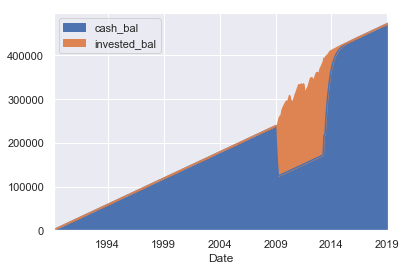

In [37]:
df.loc[:, ['cash_bal', 'invested_bal']].plot.area()

Ok. That's a decent return. Let's see how it compares to an investment where you just invest your contribution into the S&P500 each month.

## Baseline 
Invest 1k per month in S&P 500 EFT.

In [38]:
df_b = df.copy()

Set df_b.buy == True. We're buying every month!

In [39]:
df_b['buy'] = True

In [40]:
df_b = invest(df_b, monthly_new_capital=1000, monthly_buy_pct = 1.0)
df_b.head()

,Value,moving_avg,moving_avg_sd,buy,sell,pct_change,cash_bal,invested_bal,total_bal,row,total_contribution,return,percent_return
Date,,,,,,,,,,,,,
1989-03-01,603.20,474.70,31.82,True,True,-0.01,0.00,"1,000.00","1,000.00",0,0,"1,000.00",inf
1989-04-01,618.94,474.35,31.70,True,True,0.03,0.00,"2,026.09","2,026.09",1,1000,"1,026.09",1.03
1989-05-01,639.05,474.00,31.60,True,True,0.03,0.00,"3,091.92","3,091.92",2,2000,"1,091.92",0.55
1989-06-01,657.41,473.89,31.53,True,True,0.03,0.00,"4,180.76","4,180.76",3,3000,"1,180.76",0.39
1989-07-01,672.44,473.99,31.46,True,True,0.02,0.00,"5,276.34","5,276.34",4,4000,"1,276.34",0.32


In [41]:
df_b.tail()

,Value,moving_avg,moving_avg_sd,buy,sell,pct_change,cash_bal,invested_bal,total_bal,row,total_contribution,return,percent_return
Date,,,,,,,,,,,,,
2018-10-01,"2,776.13","1,757.55",287.44,True,True,-0.04,0.00,"782,000.88","782,000.88",355,355000,"427,000.88",1.20
2018-11-01,"2,723.23","1,761.57",286.95,True,True,-0.02,0.00,"768,099.61","768,099.61",356,356000,"412,099.61",1.16
2018-12-01,"2,567.31","1,764.64",286.46,True,True,-0.06,0.00,"725,121.66","725,121.66",357,357000,"368,121.66",1.03
2019-01-01,"2,584.96","1,767.43",285.97,True,True,0.01,0.00,"731,106.79","731,106.79",358,358000,"373,106.79",1.04
2019-02-01,"2,706.71","1,770.75",285.50,True,True,0.05,0.00,"766,541.47","766,541.47",359,359000,"407,541.47",1.14


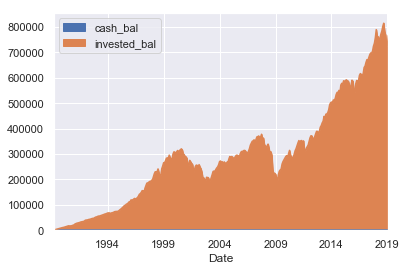

In [42]:
df_b.loc[:, ['cash_bal', 'invested_bal']].plot.area()

You would have been much better off investing every month than following the earlier market timing strategy.

## Playing with investment options

Sell or buy 50% of holdings or cash each time.

In [44]:
df_bets = df.copy()
df_bets = invest(df_bets, monthly_new_capital=1000, monthly_buy_pct = .5, monthly_sell_pct = .5)
df_bets.tail()

,Value,moving_avg,moving_avg_sd,buy,sell,pct_change,cash_bal,invested_bal,total_bal,row,total_contribution,return,percent_return
Date,,,,,,,,,,,,,
2018-10-01,"2,776.13","1,757.55",287.44,False,True,-0.04,"545,964.02",0.00,"545,964.02",355,355000,"190,964.02",0.54
2018-11-01,"2,723.23","1,761.57",286.95,False,True,-0.02,"546,964.02",0.00,"546,964.02",356,356000,"190,964.02",0.54
2018-12-01,"2,567.31","1,764.64",286.46,False,True,-0.06,"547,964.02",0.00,"547,964.02",357,357000,"190,964.02",0.53
2019-01-01,"2,584.96","1,767.43",285.97,False,True,0.01,"548,964.02",0.00,"548,964.02",358,358000,"190,964.02",0.53
2019-02-01,"2,706.71","1,770.75",285.50,False,True,0.05,"549,964.02",0.00,"549,964.02",359,359000,"190,964.02",0.53


Let's try changing our buy and sell points. Let's try both at .5 sd from the moving average. 

In [45]:
df['sell'] = df.Value > (df.moving_avg +(0.5 *  df.moving_avg_sd))
df['buy'] = df.Value < (df.moving_avg - (0.5 * df.moving_avg_sd))

In [46]:
df_sd = df.copy()

In [47]:
df_sd = invest(df_sd, monthly_new_capital=1000, monthly_buy_pct = 0.5, monthly_sell_pct = 0.5)
df_sd.tail()

,Value,moving_avg,moving_avg_sd,buy,sell,pct_change,cash_bal,invested_bal,total_bal,row,total_contribution,return,percent_return
Date,,,,,,,,,,,,,
2018-10-01,"2,776.13","1,757.55",287.44,False,True,-0.04,"464,640.87",0.00,"464,640.87",355,355000,"109,640.87",0.31
2018-11-01,"2,723.23","1,761.57",286.95,False,True,-0.02,"465,640.87",0.00,"465,640.87",356,356000,"109,640.87",0.31
2018-12-01,"2,567.31","1,764.64",286.46,False,True,-0.06,"466,640.87",0.00,"466,640.87",357,357000,"109,640.87",0.31
2019-01-01,"2,584.96","1,767.43",285.97,False,True,0.01,"467,640.87",0.00,"467,640.87",358,358000,"109,640.87",0.31
2019-02-01,"2,706.71","1,770.75",285.50,False,True,0.05,"468,640.87",0.00,"468,640.87",359,359000,"109,640.87",0.31


That didn't work well, either. 

# Conclusion
## Future directions


Use plotly to make pretty graphs.

Make a monte carlo simulation to look at different chunks of history.

Play with different start dates, rolling average windows, different variations from the average, and different allocation percentags.

My take away, based on this study and a previous study I conducted on buying when stocks are cheap (as determined by PE or 10 Year PE ratios) is that it's really hard to time the market. Despite what Nate Silver suggests in the Signal and the Noise and despite the investment cliche. Just dollar cost average in the stock market for the best shot at a good return.

None of this should be construed as investment advice. I'm not an expert. Past performance is not necessarily predictive of future performance. Predicting markets is humbling. But it's fun, and educational to try to beat the market with Python.

## Have fun!